In [85]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable, Literal

from fairdivision.algorithms.envy_cycle_elimination import envy_cycle_elimination
from fairdivision.algorithms.draft_and_eliminate import draft_and_eliminate
from fairdivision.algorithms.ordered_picking import ordered_picking
from fairdivision.algorithms.round_robin import round_robin
from fairdivision.algorithms.xp_ece import xp_ece
from fairdivision.db.db_importer import get_instance, get_instances_with_discrete_allocations 
from fairdivision.utils.checkers import is_ef1, is_efx0, is_prop, is_ef

RANDOMIZED_ALGORITHMS = [
    ("XP-ECE", xp_ece)
]

DETERMINISTIC_ALGORITHMS = [
    ("Envy-Cycle Elimination", envy_cycle_elimination),
    ("Draft-and-Eliminate", draft_and_eliminate),
    ("Ordered Picking", ordered_picking),
    ("Round-Robin", lambda agents, items: round_robin(agents, items)[0])
]

In [86]:
def run_and_draw(
    property_name: str, 
    randomized_algorithms: list[tuple[str, Callable]] = RANDOMIZED_ALGORITHMS,
    deterministic_algorithms: list[tuple[str, Callable]] = DETERMINISTIC_ALGORITHMS, 
    randomized_iterations: int = 100,
    dataset: Literal["real"] | Literal["demo"] = "real") -> tuple[int, dict[str, int]]:

    if property_name == "EF1":
        satisfies_property = lambda agents, _, allocation: is_ef1(agents, allocation) == True
    elif property_name == "EFX_0":
        satisfies_property = lambda agents, _, allocation: is_efx0(agents, allocation) == True
    elif property_name == "PROP":
        satisfies_property = lambda agents, items, allocation: is_prop(agents, items, allocation) == True
    elif property_name == "EF":
        satisfies_property = lambda agents, _, allocation: is_ef(agents, allocation) == True
    else:
        raise Exception(f"Property {property_name} is not supported")

    instances_ids = get_instances_with_discrete_allocations(dataset)
    
    satisfied_per_randomized_algorithm = dict()
    satisfied_per_deterministic_algorithm = dict()

    for algorithm_name, _ in randomized_algorithms:
        satisfied_per_randomized_algorithm[algorithm_name] = [0 for _ in range(randomized_iterations)]
    
    for algorithm_name, _ in deterministic_algorithms:
        satisfied_per_deterministic_algorithm[algorithm_name] = 0

    for instance_id in instances_ids:
        agents, items = get_instance(instance_id, dataset)

        for algorithm_name, algorithm in randomized_algorithms:
            for i in range(randomized_iterations):
                allocation = algorithm(agents, items)
        
                if satisfies_property(agents, items, allocation):
                    satisfied_per_randomized_algorithm[algorithm_name][i] += 1
    
        for algorithm_name, algorithm in deterministic_algorithms:
            allocation = algorithm(agents, items)
    
            if satisfies_property(agents, items, allocation):
                satisfied_per_deterministic_algorithm[algorithm_name] += 1

    x = list(satisfied_per_randomized_algorithm.keys()) + list(satisfied_per_deterministic_algorithm.keys())

    y_randomized = list(map(lambda data: round(np.mean(data)), satisfied_per_randomized_algorithm.values()))
    y = y_randomized + list(satisfied_per_deterministic_algorithm.values())

    plt.figure(figsize=(15, 6))

    plt.ylim(0, len(instances_ids))

    plt.xlabel("Algorithm")
    plt.ylabel(f"Number of {property_name} allocations")

    bar_color = ["lightsteelblue", "mediumseagreen", "navajowhite", "lightcoral", "plum"]

    plt.bar(x, y, color=bar_color, width = 0.4)

    for i, (algorithm_name, _) in enumerate(randomized_algorithms):
        mean = np.mean(satisfied_per_randomized_algorithm[algorithm_name])
        std = np.std(satisfied_per_randomized_algorithm[algorithm_name])

        int_std = max(round(abs(round(mean) - (mean + std))), round(abs(round(mean) - (mean - std))))

        plt.errorbar(x[i], y[i], yerr=int_std, capsize=4, color="black")
        plt.text(i, y[i] // 2, f"{y[i]} +/- {int_std}", ha = 'center')
    
    for i in range(len(randomized_algorithms), len(x)):
        plt.text(i, y[i] // 2, str(y[i]), ha = 'center')
     
    plt.title(f"Number of {property_name} allocations per algorithm for Spliddit data")

    plt.show()

## Real data

### EF1

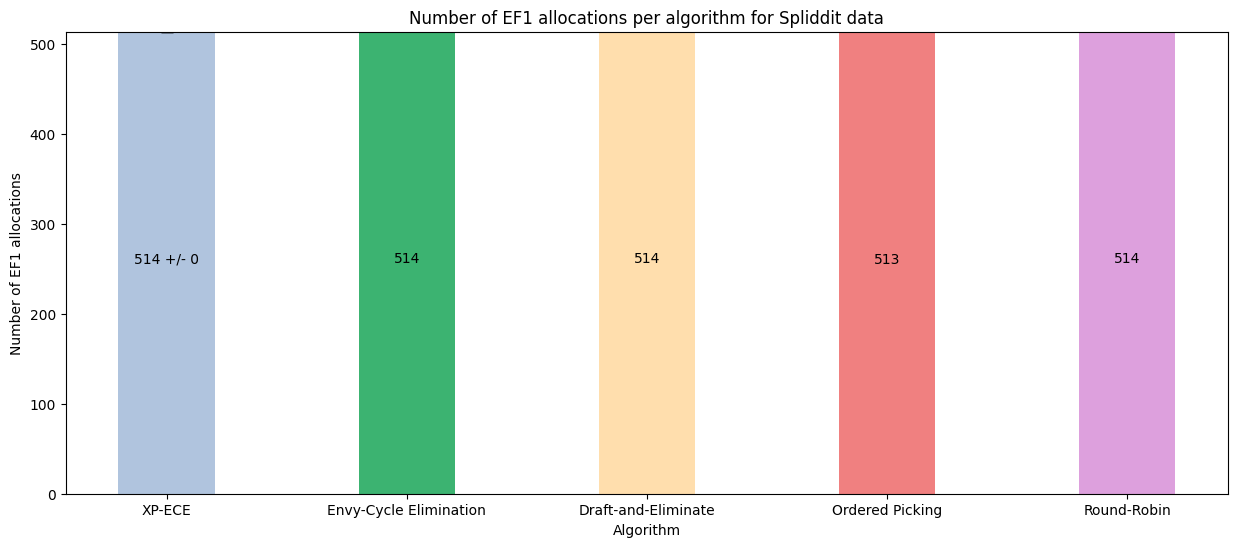

In [76]:
run_and_draw("EF1")

### $\textnormal{EFX}_0$

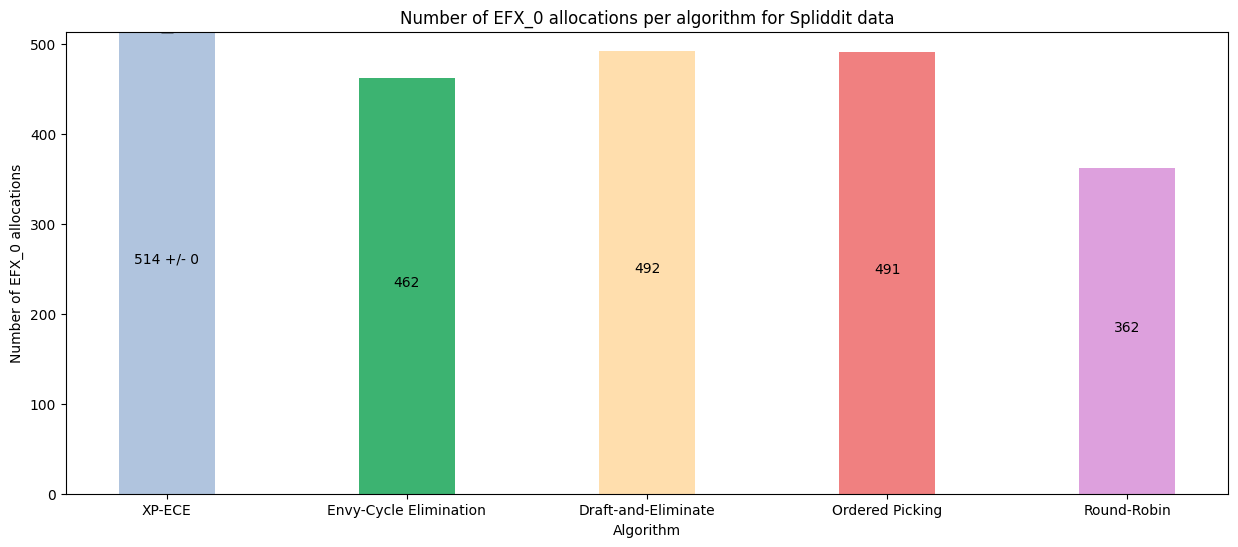

In [77]:
run_and_draw("EFX_0")

### PROP

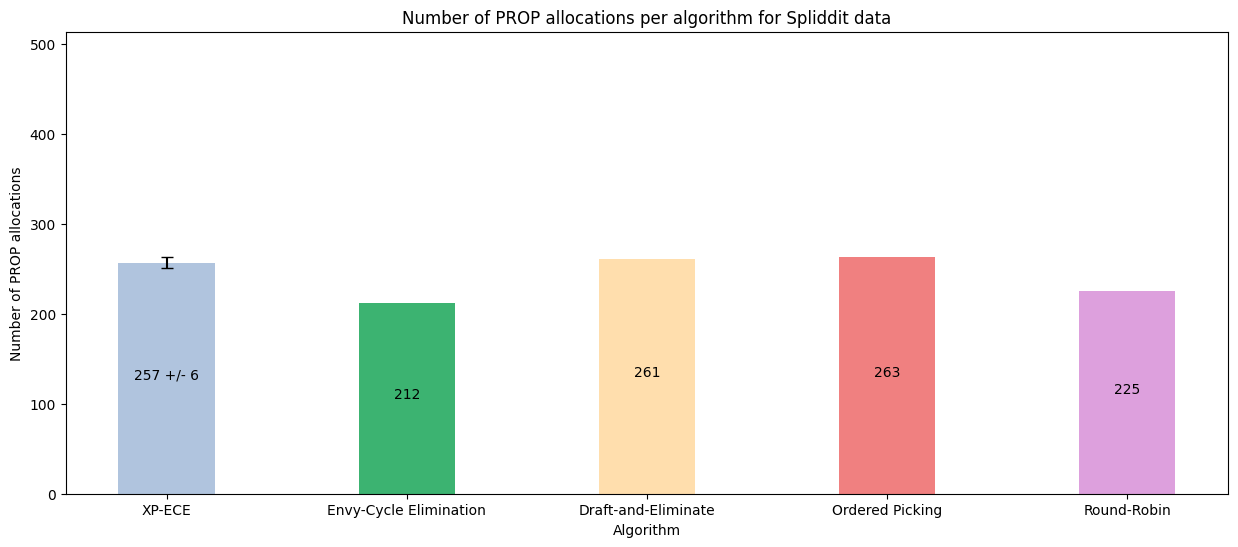

In [78]:
run_and_draw("PROP")

### EF

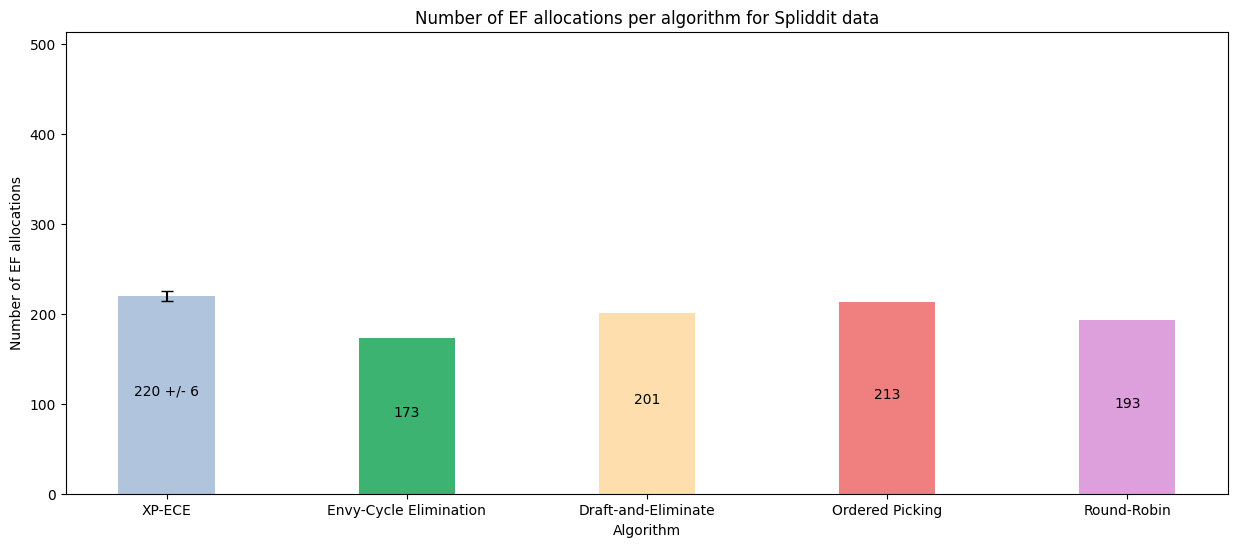

In [79]:
run_and_draw("EF")

## Demo data

### EF1

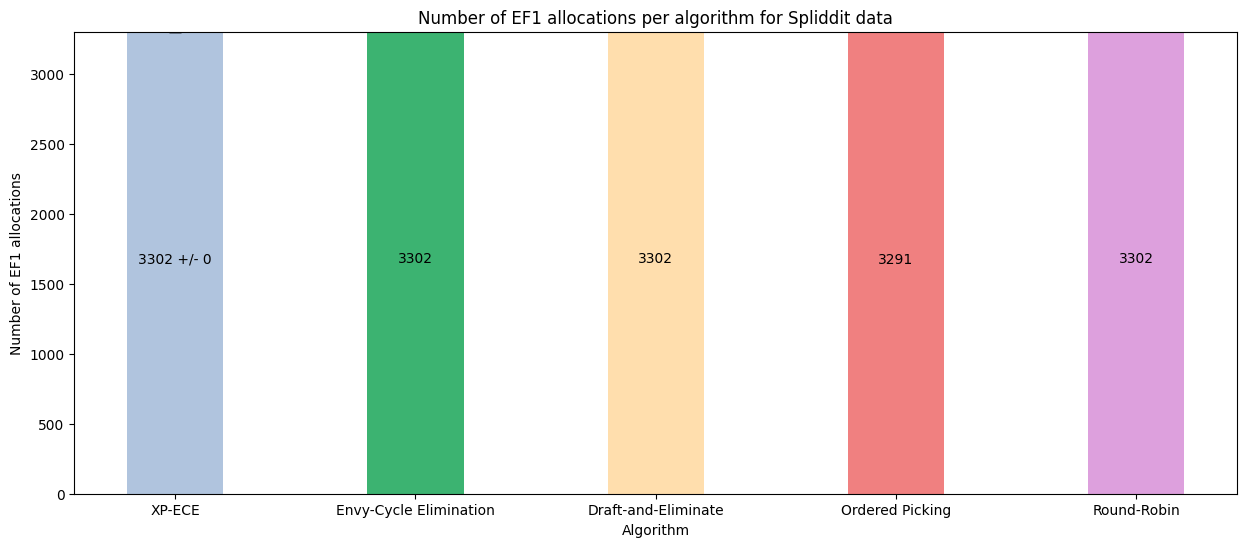

In [87]:
run_and_draw("EF1", dataset="demo")

### $\textnormal{EFX}_0$

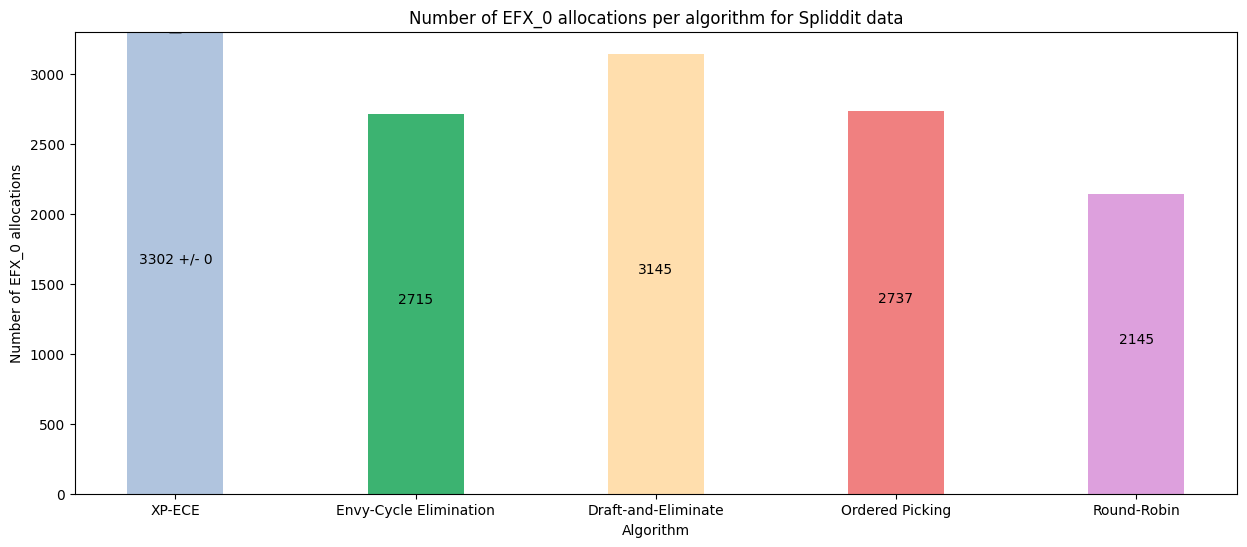

In [88]:
run_and_draw("EFX_0", dataset="demo")

### PROP

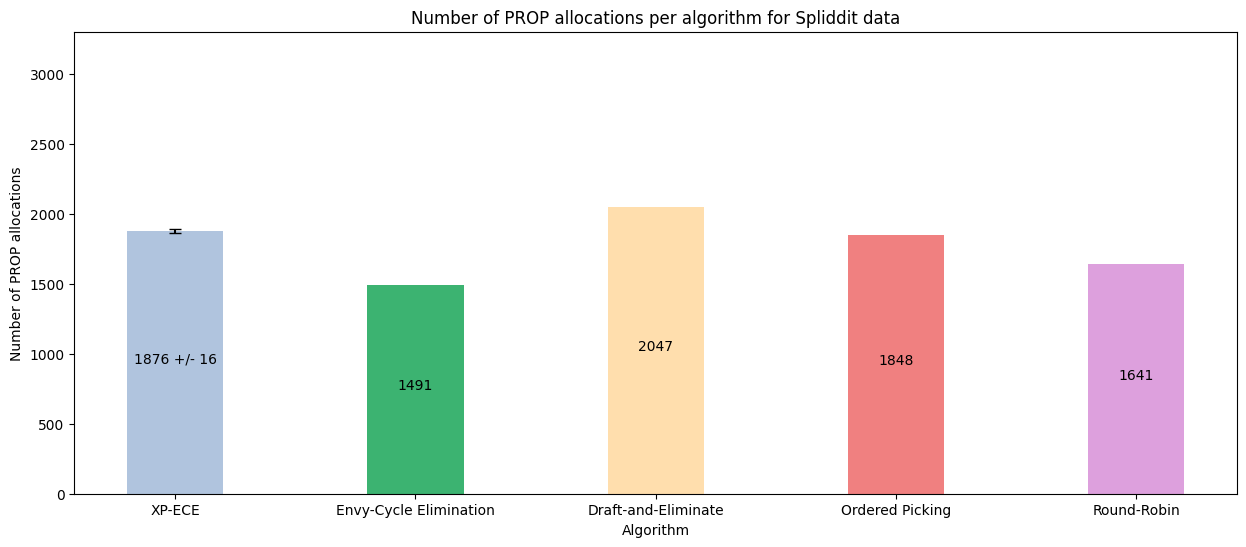

In [89]:
run_and_draw("PROP", dataset="demo")

### EF

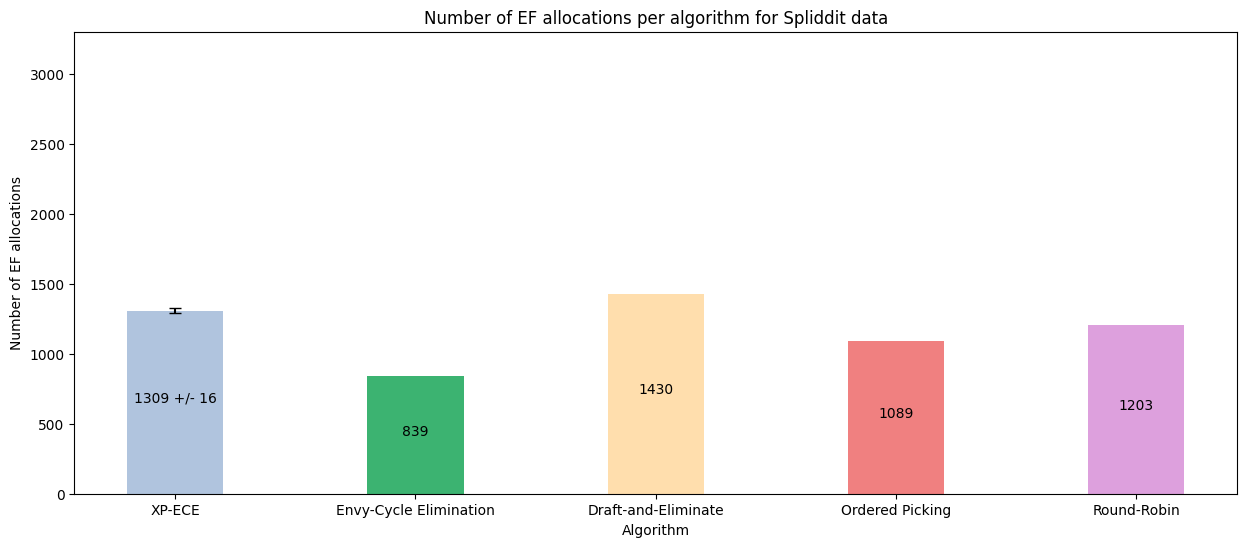

In [90]:
run_and_draw("EF", dataset="demo")